In [1]:
%matplotlib inline

import sys
import time
import copy
import itertools

import pandas as pd
import numpy as np

from datetime import timedelta
from utils import *

sys.path.append('./')

In [2]:
def build_graph_mdl_heuristic(pathname):
    Primary_Graph = {}
    Graph_Winners = []
    Graph_Candidates = []
    Graph_Candidates_Sorted = []
    Cycle_Flags = []
    MDL = []
    data = pd.read_table(pathname, sep="\t")
    vertices = list(data.columns)
    MI_Pairs = {}
    Total_Graphs = 0
    vertices_combinations = list(itertools.combinations(vertices, 2))
    start = time.time()
    for (item_1, item_2) in vertices_combinations:
        MI_Pairs[(item_1, item_2)] = calculate_mi(data, item_1, item_2)
    MI_Pairs_sorted = dict(sorted(MI_Pairs.items(), key=lambda x: x[1], reverse=True))
    mi_pairs_logs = copy.deepcopy(MI_Pairs_sorted)
    k = 1
    for vertex in vertices:
        Primary_Graph[vertex] = []
    Graph_Winners.append(Primary_Graph)
    while (MI_Pairs_sorted):
        k += 1
        max_MI_key = list(MI_Pairs_sorted.keys())[0]
        max_MI_value = MI_Pairs_sorted[max_MI_key]
        MDL_Current = calculate_MDL_of_graph(data, Graph_Winners[0])
        Graph_Candidates.clear()
        Graph_Candidates_Sorted.clear()
        Cycle_Flags.clear()
        vertex_1, vertex_2 = max_MI_key
        del MI_Pairs_sorted[max_MI_key]
        for Graph in Graph_Winners:
            Graph_1 = copy.deepcopy(Graph)
            Graph_2 = copy.deepcopy(Graph)
            Graph_3 = copy.deepcopy(Graph)
            Graph_1[vertex_2].append(vertex_1)
            Graph_2[vertex_1].append(vertex_2)
            Graph_Candidates.append({"Struct": Graph_1, "L": 0})
            Graph_Candidates.append({"Struct": Graph_2, "L": 0})
            Graph_Candidates.append({"Struct": Graph_3, "L": 0})
        Total_Graphs += len(Graph_Candidates)
        for Graph_Item in Graph_Candidates:
            Graph = Graph_Item["Struct"]
            Cycle_Flags.append(cyclic(Graph))
        if (any(Cycle_Flags)):
            MDL.append(MDL_Current)
            continue
        else:
            for Graph_Item in Graph_Candidates:
                Graph = Graph_Item["Struct"]
                Graph_Item["L"] = calculate_MDL_of_graph(data, Graph)
            Graph_Candidates_Sorted = sorted(Graph_Candidates, key= lambda d: d["L"])
            L_Min = Graph_Candidates_Sorted[0]["L"]
            Graph_Winners.clear()
            for G_C in Graph_Candidates_Sorted:
                if (G_C["L"] == L_Min):
                    Graph_Winners.append(G_C["Struct"])
            MDL.append(L_Min)
    end = time.time()
    elapsed = end - start
    return mi_pairs_logs, MDL, Graph_Winners, str(timedelta(seconds=elapsed)), Total_Graphs

In [3]:
def structural_difference(Etalon_Graph, built_graph):
    parent_vertices = []
    symmetric_differences = []
    symmetric_differences_card = []
    for vertex in Etalon_Graph:
        parent_vertices.append([Etalon_Graph[vertex], built_graph[vertex]])
    Table = pd.DataFrame(parent_vertices, columns=["Etalon Graph Parent Vertices", "Built Graph Parent Vertices"], index=list(Etalon_Graph.keys()))
    for vertex in Table.index:
        sym_diff = list(set(Table["Etalon Graph Parent Vertices"][vertex]).symmetric_difference(set(Table["Built Graph Parent Vertices"][vertex])))
        symmetric_differences.append(sym_diff)
        symmetric_differences_card.append(len(sym_diff))
    Table["Symmetric Difference"] = symmetric_differences
    Table["Symmetric Difference Card"] = symmetric_differences_card
    Table.index.name = "Vertex"
    Sum = Table['Symmetric Difference Card'].sum()
    return Table, Sum

In [4]:
mi_pairs_values, mdl_history, optimal_graph, took_time, total_models = build_graph_mdl_heuristic("./asia/Asia.txt")
print(f'Time: {took_time}')
print(f'N models: {total_models}')
optimal_graph

Time: 0:00:02.797535
N models: 126


[{'Smoke': ['Bronchitis'],
  'Cancer': ['Tub_or_Cancer'],
  'Tuberculosis': ['Tub_or_Cancer'],
  'Tub_or_Cancer': ['X_Ray'],
  'Asia': ['Tuberculosis'],
  'X_Ray': [],
  'Bronchitis': ['dyspnea'],
  'dyspnea': ['Tub_or_Cancer']}]

In [5]:
print(mi_pairs_values)

{('Bronchitis', 'dyspnea'): 0.25172779490288477, ('Cancer', 'Tub_or_Cancer'): 0.13627859181846003, ('Tub_or_Cancer', 'X_Ray'): 0.12597634556056508, ('Cancer', 'X_Ray'): 0.09643837013930524, ('Smoke', 'Bronchitis'): 0.04895159225394096, ('Tuberculosis', 'Tub_or_Cancer'): 0.03640365483895031, ('Tuberculosis', 'X_Ray'): 0.025060313257108828, ('Smoke', 'dyspnea'): 0.024577740448001928, ('Tub_or_Cancer', 'dyspnea'): 0.013289650792134329, ('Cancer', 'dyspnea'): 0.010142005946990176, ('X_Ray', 'dyspnea'): 0.005094015213607014, ('Smoke', 'Cancer'): 0.0030274974935237025, ('Tuberculosis', 'dyspnea'): 0.0028670665723796226, ('Smoke', 'Tub_or_Cancer'): 0.002260747519352644, ('Tuberculosis', 'Asia'): 0.0012276976904070714, ('Smoke', 'X_Ray'): 0.0008505239604480437, ('Cancer', 'Bronchitis'): 0.0005085585076306811, ('Tuberculosis', 'Bronchitis'): 0.0003807044034175879, ('Tub_or_Cancer', 'Asia'): 0.00026645074865278104, ('Smoke', 'Asia'): 0.00019768924547305087, ('Tub_or_Cancer', 'Bronchitis'): 0.000

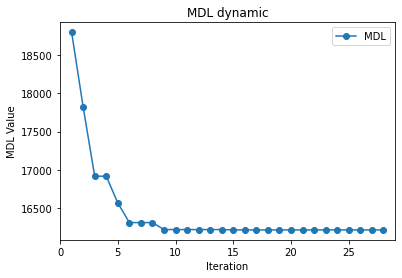

In [6]:
from matplotlib import pyplot as plt

plt.xlim(0, len(mdl_history) + 1)
plt.plot(range(1, len(mdl_history) + 1), mdl_history , marker = "o", label = "MDL")
plt.xlabel("Iteration")
plt.ylabel("MDL Value")
plt.title("MDL dynamic")
plt.legend()
plt.show()

In [7]:
original_graph = {
    "Asia": [],
    "Smoke": [],
    "Tuberculosis": ["Asia"],
    "Cancer": ["Smoke"],
    "Bronchitis": ["Smoke"],
    "Tub_or_Cancer": ["Tuberculosis", "Cancer"],
    "X_Ray": ["Tub_or_Cancer"],
    "dyspnea": ["Tub_or_Cancer", "Bronchitis"]
}

Table, metric_value = structural_difference(original_graph, optimal_graph[0])
print(optimal_graph[0])
print("Sum:", metric_value)
print()
Table

{'Smoke': ['Bronchitis'], 'Cancer': ['Tub_or_Cancer'], 'Tuberculosis': ['Tub_or_Cancer'], 'Tub_or_Cancer': ['X_Ray'], 'Asia': ['Tuberculosis'], 'X_Ray': [], 'Bronchitis': ['dyspnea'], 'dyspnea': ['Tub_or_Cancer']}
Sum: 13



,Etalon Graph Parent Vertices,Built Graph Parent Vertices,Symmetric Difference,Symmetric Difference Card
Vertex,,,,
Asia,[],[Tuberculosis],[Tuberculosis],1
Smoke,[],[Bronchitis],[Bronchitis],1
Tuberculosis,[Asia],[Tub_or_Cancer],"[Tub_or_Cancer, Asia]",2
Cancer,[Smoke],[Tub_or_Cancer],"[Tub_or_Cancer, Smoke]",2
Bronchitis,[Smoke],[dyspnea],"[dyspnea, Smoke]",2
Tub_or_Cancer,"[Tuberculosis, Cancer]",[X_Ray],"[X_Ray, Cancer, Tuberculosis]",3
X_Ray,[Tub_or_Cancer],[],[Tub_or_Cancer],1
dyspnea,"[Tub_or_Cancer, Bronchitis]",[Tub_or_Cancer],[Bronchitis],1


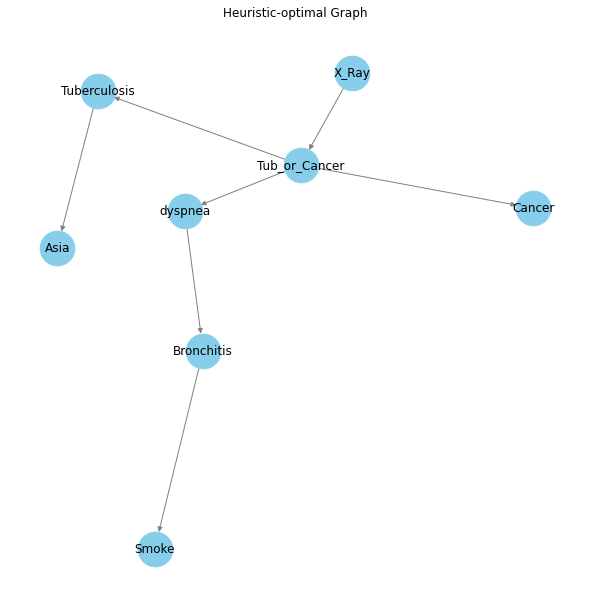

In [8]:
import networkx as nx


G = nx.DiGraph(directed=True)
data = pd.read_table("./asia/Asia.txt", sep="\t")
G.add_nodes_from(list(data.columns))
for vertex in optimal_graph[0]:
    for item in optimal_graph[0][vertex]:
        G.add_edge(item, vertex)

node_size = 1200
node_color = 'skyblue'
node_shape = 'o'
edge_color = 'gray'
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=node_size, node_color=node_color, 
        edge_color=edge_color, with_labels=True)

labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Heuristic-optimal Graph")
plt.show()